In [57]:
import xarray as xr
from dask.diagnostics import ProgressBar
import numpy as np
import pandas as pd
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline
import seaborn as sb
from itertools import cycle

sys.path.append('/workspace/bkraft/dl_chapter14/src')
from utils.plotting import plot_map, subplots_robinson, plot_scatter, plot_hist2d, plot_hexbin
from utils.metrics import get_metrics, xr_quantile

In [2]:
fig_width_pt = 443.57848                # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.                # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "xelatex",         # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],  # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 9,                # LaTeX default is 10pt font.
    "axes.titlesize": 9,
    "font.size": 7,
    "legend.fontsize": 9,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "figure.figsize": fig_size,        # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ],
    'axes.linewidth': 0.5,
    'xtick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    'ytick.major.width': 0.5,
    'ytick.minor.width': 0.5
    }
mpl.rcParams.update(pgf_with_latex)

def new_subplots(nrow, ncol, wh_ratio, width=1, **kwargs):
    plt.clf()
    fig, ax = plt.subplots(nrow, ncol, figsize=fig_size, **kwargs)
    return fig, ax

def savefig(filename, **kwargs):
    #plt.savefig('{}.pgf'.format(filename), pad_inches = 0, bbox_inches='tight')
    plt.savefig('{}.pdf'.format(filename), pad_inches = 0.05, bbox_inches='tight', **kwargs)

In [48]:
fig_size

[6.160812222222222, 3.8075913516391036]

In [4]:
data = xr.open_zarr('/scratch/dl_chapter14/data/data.zarr/')

In [4]:
data.pft

,Array,Chunk
Bytes,1.04 MB,400 B
Shape,"(360, 720)","(10, 10)"
Count,2593 Tasks,2592 Chunks
Type,float32,numpy.ndarray


In [5]:
def subset_region(ds, region):
    return ds.where(ds.pft==region, np.nan)

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


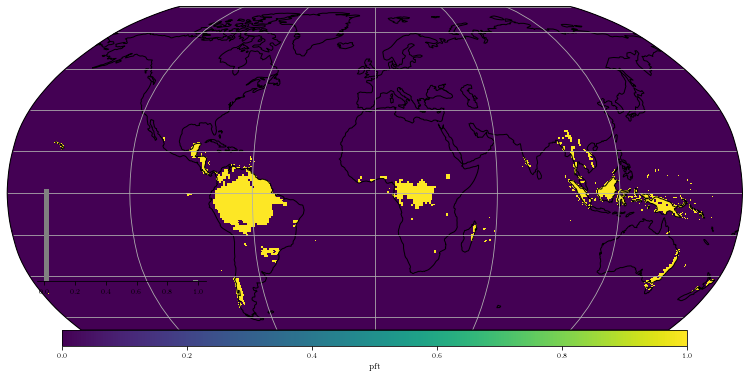

In [6]:
plot_map(data.pft==2)

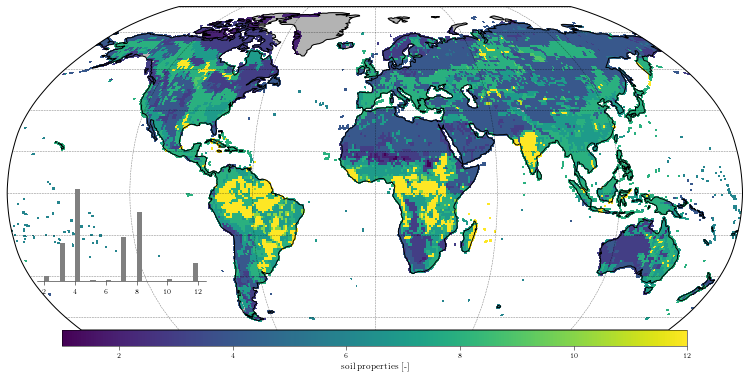

In [63]:
plot_map(data.soil_properties)

### Data

In [11]:
dss_nn = xr.open_zarr('/scratch/dl_chapter14/experiments/et/n_sm.n_perm/inference/pred_so.zarr/') *  86400 # 1 kg/m2/s = 86400 mm/day
dss_wn = xr.open_zarr('/scratch/dl_chapter14/experiments/et/w_sm.n_perm/inference/pred_so.zarr/') *  86400 # 1 kg/m2/s = 86400 mm/day
dss_nw = xr.open_zarr('/scratch/dl_chapter14/experiments/et/n_sm.w_perm/inference/pred_so.zarr/') *  86400 # 1 kg/m2/s = 86400 mm/day
dss_ww = xr.open_zarr('/scratch/dl_chapter14/experiments/et/w_sm.w_perm/inference/pred_so.zarr/') *  86400 # 1 kg/m2/s = 86400 mm/day

dst_nn = xr.open_zarr('/scratch/dl_chapter14/experiments/et/n_sm.n_perm/inference/pred_to.zarr/') *  86400 # 1 kg/m2/s = 86400 mm/day
dst_wn = xr.open_zarr('/scratch/dl_chapter14/experiments/et/w_sm.n_perm/inference/pred_to.zarr/') *  86400 # 1 kg/m2/s = 86400 mm/day
dst_nw = xr.open_zarr('/scratch/dl_chapter14/experiments/et/n_sm.w_perm/inference/pred_to.zarr/') *  86400 # 1 kg/m2/s = 86400 mm/day
dst_ww = xr.open_zarr('/scratch/dl_chapter14/experiments/et/w_sm.w_perm/inference/pred_to.zarr/') *  86400 # 1 kg/m2/s = 86400 mm/day

dst_nn_tr = xr.open_zarr('/scratch/dl_chapter14/experiments/et/n_sm.n_perm/inference/pred_to_trainset.zarr/') *  86400 # 1 kg/m2/s = 86400 mm/day
dst_wn_tr = xr.open_zarr('/scratch/dl_chapter14/experiments/et/w_sm.n_perm/inference/pred_to_trainset.zarr/') *  86400 # 1 kg/m2/s = 86400 mm/day
dst_nw_tr = xr.open_zarr('/scratch/dl_chapter14/experiments/et/n_sm.w_perm/inference/pred_to_trainset.zarr/') *  86400 # 1 kg/m2/s = 86400 mm/day
dst_ww_tr = xr.open_zarr('/scratch/dl_chapter14/experiments/et/w_sm.w_perm/inference/pred_to_trainset.zarr/') *  86400 # 1 kg/m2/s = 86400 mm/day

for ds in [dss_nn, dss_nn, dss_nn, dss_nn, dst_nn, dst_nn, dst_nn, dst_nn]:
    ds.mod.attrs['units'] = r'$mm day^{-1}$'
    ds.obs.attrs['units'] = r'$mm day^{-1}$'
    ds.mod.attrs['long_name'] = 'ET'
    ds.obs.attrs['long_name'] = 'ET'

### Aggregate to monthly

In [8]:
dst_nn_m = dst_nn.resample(time='1MS', keep_attrs=True).mean('time', keep_attrs=True).compute()
dst_wn_m = dst_wn.resample(time='1MS', keep_attrs=True).mean('time', keep_attrs=True).compute()
dst_nw_m = dst_nw.resample(time='1MS', keep_attrs=True).mean('time', keep_attrs=True).compute()
dst_ww_m = dst_ww.resample(time='1MS', keep_attrs=True).mean('time', keep_attrs=True).compute()

dst_nn_tr_m = dst_nn_tr.resample(time='1MS', keep_attrs=True).mean('time', keep_attrs=True).compute()
dst_wn_tr_m = dst_wn_tr.resample(time='1MS', keep_attrs=True).mean('time', keep_attrs=True).compute()
dst_nw_tr_m = dst_nw_tr.resample(time='1MS', keep_attrs=True).mean('time', keep_attrs=True).compute()
dst_ww_tr_m = dst_ww_tr.resample(time='1MS', keep_attrs=True).mean('time', keep_attrs=True).compute()

/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.p

### MSC and anomalies

In [9]:
def add_msc_and_ano(ds, time_agg='month'):
    for s in ['mod', 'obs']:
        msc = ds[s].groupby('time.' + time_agg).mean('time', keep_attrs=True).compute()
        ano = (ds[s].groupby('time.' + time_agg) - msc).compute()
        if time_agg == 'month':
            msc[time_agg] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
        iav = ds[s].groupby('time.year').mean('time', keep_attrs=True)
        iav -= iav.mean('year')
        ds[s + '_msc'] = msc
        ds[s + '_ano'] = ano
        ds[s + '_iav'] = iav.compute()
    return ds
i = 0
for ds in [dst_nn, dst_wn, dst_nw, dst_ww, dst_nn_tr, dst_wn_tr, dst_nw_tr, dst_ww_tr]:
    i += 1
    print(i)
    ds = add_msc_and_ano(ds)
for ds in [dst_nn_m, dst_wn_m, dst_nw_m, dst_ww_m, dst_nn_tr_m, dst_wn_tr_m, dst_nw_tr_m, dst_ww_tr_m]:
    i += 1
    print(i)
    ds = add_msc_and_ano(ds)

1


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 14 times more chunks
  return self.array[key]
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 14 times more chunks
  return self.array[key]
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 14 times more chunks
  return self.array[key]
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 14 times more chunks
  return self.array[key]
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


3


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 14 times more chunks
  return self.array[key]
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 14 times more chunks
  return self.array[key]
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


4


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 14 times more chunks
  return self.array[key]
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 14 times more chunks
  return self.array[key]
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


5


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


6


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 20 times more chunks
  return self.array[key]
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


7


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 15 times more chunks
  return self.array[key]
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 15 times more chunks
  return self.array[key]
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


8


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 15 times more chunks
  return self.array[key]
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/xarray/core/indexing.py:1343: PerformanceWarning: Slicing with an out-of-order index is generating 15 times more chunks
  return self.array[key]
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


9


/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


10


/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


11


/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


12


/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


13


/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


14


/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


15


/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


16


/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [10]:
target_dir = '/scratch/dl_chapter14/experiments/et/derived'
if not os.path.isdir(target_dir):
    %mkdir {target_dir}

In [11]:
for ds, ds_name in zip(
        [dst_nn, dst_wn, dst_nw, dst_ww, dst_nn_m, dst_wn_m, dst_nw_m, dst_ww_m, dst_nn_tr, dst_wn_tr, dst_nw_tr, dst_ww_tr, dst_nn_tr_m, dst_wn_tr_m, dst_nw_tr_m, dst_ww_tr_m],
        ['dst_nn', 'dst_wn', 'dst_nw', 'dst_ww', 'dst_nn_m', 'dst_wn_m', 'dst_nw_m', 'dst_ww_m', 'dst_nn_tr', 'dst_wn_tr', 'dst_nw_tr', 'dst_ww_tr', 'dst_nn_tr_m', 'dst_wn_tr_m', 'dst_nw_tr_m', 'dst_ww_tr_m']):
    print(ds_name)
    with ProgressBar():
        ds.to_netcdf(f'/scratch/dl_chapter14/experiments/et/derived/{ds_name}.nc')

dst_nn
[########################################] | 100% Completed | 15min 37.5s
dst_wn
[########################################] | 100% Completed | 14min 56.4s
dst_nw
[########################################] | 100% Completed | 14min 52.7s
dst_ww
[########################################] | 100% Completed | 15min  8.8s
dst_nn_m
dst_wn_m
dst_nw_m
dst_ww_m
dst_nn_tr
[########################################] | 100% Completed | 21min  2.4s
dst_wn_tr
[########################################] | 100% Completed | 21min  2.6s
dst_nw_tr
[########################################] | 100% Completed | 15min 45.2s
dst_ww_tr
[########################################] | 100% Completed | 16min  5.4s
dst_nn_tr_m
dst_wn_tr_m
dst_nw_tr_m
dst_ww_tr_m


### Spatial analysis

In [8]:
dst_nn.mod

<xarray.DataArray 'mod' (time: 5114, lat: 360, lon: 720)>
[1325548800 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2013-12-31
Attributes:
    units:      $mm day^{-1}$
    long_name:  ET

In [4]:
dst_nn = xr.open_dataset('/scratch/dl_chapter14/experiments/et/derived/dst_nn.nc')
dst_wn = xr.open_dataset('/scratch/dl_chapter14/experiments/et/derived/dst_wn.nc')
dst_nw = xr.open_dataset('/scratch/dl_chapter14/experiments/et/derived/dst_nw.nc')
dst_ww = xr.open_dataset('/scratch/dl_chapter14/experiments/et/derived/dst_ww.nc')
dst_nn_m = xr.open_dataset('/scratch/dl_chapter14/experiments/et/derived/dst_nn_m.nc')
dst_wn_m = xr.open_dataset('/scratch/dl_chapter14/experiments/et/derived/dst_wn_m.nc')
dst_nw_m = xr.open_dataset('/scratch/dl_chapter14/experiments/et/derived/dst_nw_m.nc')
dst_ww_m = xr.open_dataset('/scratch/dl_chapter14/experiments/et/derived/dst_ww_m.nc')

dst_nn_tr = xr.open_dataset('/scratch/dl_chapter14/experiments/et/derived/dst_nn_tr.nc')
dst_wn_tr = xr.open_dataset('/scratch/dl_chapter14/experiments/et/derived/dst_wn_tr.nc')
dst_nw_tr = xr.open_dataset('/scratch/dl_chapter14/experiments/et/derived/dst_nw_tr.nc')
dst_ww_tr = xr.open_dataset('/scratch/dl_chapter14/experiments/et/derived/dst_ww_tr.nc')
dst_nn_tr_m = xr.open_dataset('/scratch/dl_chapter14/experiments/et/derived/dst_nn_tr_m.nc')
dst_wn_tr_m = xr.open_dataset('/scratch/dl_chapter14/experiments/et/derived/dst_wn_tr_m.nc')
dst_nw_tr_m = xr.open_dataset('/scratch/dl_chapter14/experiments/et/derived/dst_nw_tr_m.nc')
dst_ww_tr_m = xr.open_dataset('/scratch/dl_chapter14/experiments/et/derived/dst_ww_tr_m.nc')

In [13]:
metrics = []
i = 0
for s, s_name in zip(['', '_msc', '_ano', '_iav'], ['raw', 'msc', 'ano', 'iav']):
    for ds, n, ts in zip(
            [dst_wn, dst_nn, dst_ww, dst_nw, dst_wn_m, dst_nn_m, dst_ww_m, dst_nw_m],
            ['wn', 'nn', 'ww', 'nw'] * 2,
            np.repeat(['daily', 'monthly'], 4)):
        i += 1
        print(i)
        ds = ds.chunk({'time': -1, 'month': -1, 'year': -1})
        if s_name == 'msc':
            timedim = 'month'
        elif s_name == 'iav':
            timedim = 'year'
        else:
            timedim = 'time'
        m = get_metrics(ds['mod' + s], ds['obs' + s], ['mef', 'rmse'], dim=timedim, verbose=False).compute()
        m = m.expand_dims({'set': [s_name], 'model': [n], 'timeres': [ts], 'cvset': ['eval']}, axis=(0, 1, 2, 3))
        metrics.append(m)

i = 0
for s, s_name in zip(['', '_msc', '_ano', '_iav'], ['raw', 'msc', 'ano', 'iav']):
    for ds, n, ts in zip(
            [dst_wn_tr, dst_nn_tr, dst_ww_tr, dst_nw_tr, dst_wn_tr_m, dst_nn_tr_m, dst_ww_tr_m, dst_nw_tr_m],
            ['wn', 'nn', 'ww', 'nw'] * 2,
            np.repeat(['daily', 'monthly'], 4)):
        i += 1
        print(i)
        ds = ds.chunk({'time': -1, 'month': -1, 'year': -1})
        if s_name == 'msc':
            timedim = 'month'
        elif s_name == 'iav':
            timedim = 'year'
        else:
            timedim = 'time'
        m = get_metrics(ds['mod' + s], ds['obs' + s], ['mef', 'rmse'], dim=timedim, verbose=False).compute()
        m = m.expand_dims({'set': [s_name], 'model': [n], 'timeres': [ts], 'cvset': ['train']}, axis=(0, 1, 2, 3))
        metrics.append(m)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [14]:
xr.merge(metrics).to_netcdf('/scratch/dl_chapter14/experiments/et/derived/spatial_metrics.nc')

In [5]:
metrics = xr.open_dataset('/scratch/dl_chapter14/experiments/et/derived/spatial_metrics.nc')

In [6]:
metrics['pft'] = data.pft.astype('int')

In [7]:
df = metrics.to_dataframe().dropna().reset_index(level=['model', 'set', 'timeres', 'cvset'])
df

cvset model  set  timeres       mef      rmse  pft
lat    lon                                                       
 82.75 -49.75   eval    nn  ano    daily  0.724082  0.102874   11
       -49.75   eval    nn  ano  monthly  0.872152  0.035251   11
       -49.75   eval    nn  iav    daily  0.820649  0.017424   11
       -49.75   eval    nn  iav  monthly  0.818567  0.017440   11
       -49.75   eval    nn  msc    daily  0.987257  0.021779   11
...              ...   ...  ...      ...       ...       ...  ...
-55.75 -67.25  train    ww  iav  monthly  0.792482  0.006949    7
       -67.25  train    ww  msc    daily  0.919469  0.091780    7
       -67.25  train    ww  msc  monthly  0.919472  0.091779    7
       -67.25  train    ww  raw    daily  0.882694  0.125273    7
       -67.25  train    ww  raw  monthly  0.915908  0.094547    7

[3240096 rows x 7 columns]

In [171]:
def q25(x):
    return x.quantile(0.25)

def q50(x):
    return x.quantile(0.50)

def q75(x):
    return x.quantile(0.75)

f = {'mef': ['mean',q25,q50,q75], 'rmse': ['mean',q25,q50,q75]}

df[
    (df.cvset   == 'eval') &
    (df.set     == 'msc') &
    (df.timeres == 'daily')
].groupby('model').agg(f).round(2)

mef                    rmse                  
       mean   q25   q50   q75  mean   q25   q50   q75
model                                                
nn     0.94  0.97  0.99  1.00  0.08  0.05  0.07  0.10
nw     0.71  0.82  0.97  0.99  0.17  0.07  0.13  0.23
wn     0.99  1.00  1.00  1.00  0.03  0.02  0.03  0.04
ww     0.91  0.95  0.99  1.00  0.10  0.06  0.08  0.12

In [56]:
def q25(x):
    return x.quantile(0.25)

def q50(x):
    return x.quantile(0.50)

def q75(x):
    return x.quantile(0.75)

f = {'mef': ['mean',q25,q50,q75], 'rmse': ['mean',q25,q50,q75]}

df[
    (df.cvset   == 'eval') &
    (df.set     == 'raw') &
    (df.timeres == 'daily') &
    (df.pft     != 2)
].groupby('model').agg(f).round(2)

mef                    rmse                  
       mean   q25   q50   q75  mean   q25   q50   q75
model                                                
nn     0.95  0.94  0.97  0.98  0.21  0.16  0.19  0.24
nw     0.76  0.67  0.89  0.95  0.41  0.26  0.33  0.50
wn     0.97  0.96  0.98  0.99  0.17  0.12  0.15  0.20
ww     0.88  0.86  0.93  0.96  0.30  0.22  0.27  0.35

In [62]:
def q25(x):
    return x.quantile(0.25)

def q50(x):
    return x.quantile(0.50)

def q75(x):
    return x.quantile(0.75)

f = {'mef': ['mean',q25,q50,q75], 'rmse': ['mean',q25,q50,q75]}

df[
    (df.cvset   == 'eval') &
    (df.set     == 'raw') &
    (df.timeres == 'daily') &
    (df.pft     == 2)
].groupby('model').agg(f).round(2)

mef                    rmse                  
       mean   q25   q50   q75  mean   q25   q50   q75
model                                                
nn     0.74  0.65  0.75  0.87  0.46  0.38  0.48  0.55
nw     0.55  0.46  0.57  0.68  0.61  0.51  0.61  0.69
wn     0.77  0.67  0.78  0.91  0.42  0.34  0.45  0.53
ww     0.67  0.56  0.69  0.81  0.52  0.45  0.55  0.62

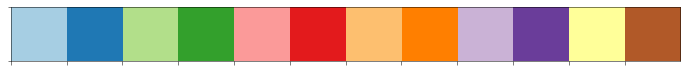

In [39]:
sb.palplot(sb.color_palette("Paired"))

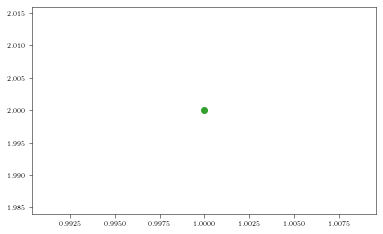

In [47]:
plt.scatter(1, 2, color=sb.color_palette("Paired")[3])

In [8]:
order = ['raw', 'msc', 'ano', 'iav']
hue_order = ['wn', 'nn', 'ww', 'nw']

<Figure size 432x288 with 0 Axes>

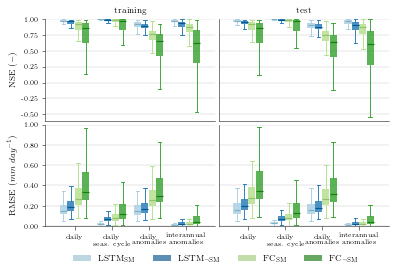

In [180]:
fig, ax = new_subplots(2, 2, 0.7, sharey='row', sharex=True, gridspec_kw={'wspace': 0.02, 'hspace': 0.04})

plot_kwargs = dict(
    order=order,
    hue_order=hue_order,
    palette='Paired'
)

p1 = sb.boxplot(x="set", y="mef", hue="model", data=df.loc[(df['timeres']=='daily') & (df['cvset']=='train'), :], showfliers=False, ax=ax[0, 0], **plot_kwargs)
p2 = sb.boxplot(x="set", y="mef", hue="model", data=df.loc[(df['timeres']=='daily') & (df['cvset']=='eval'), :], showfliers=False, ax=ax[0, 1], **plot_kwargs)
p3 = sb.boxplot(x="set", y="rmse", hue="model", data=df.loc[(df['timeres']=='daily') & (df['cvset']=='train'), :], showfliers=False, ax=ax[1, 0], **plot_kwargs)
p4 = sb.boxplot(x="set", y="rmse", hue="model", data=df.loc[(df['timeres']=='daily') & (df['cvset']=='eval'), :], showfliers=False, ax=ax[1, 1], **plot_kwargs)

ax[0, 0].legend().set_visible(False)
ax[0, 1].legend().set_visible(False)
ax[1, 0].legend().set_visible(False)
ax[1, 1].legend().set_visible(False)

ax[1, 0].set_xticklabels(['daily', 'daily\nseas. cycle', 'daily\nanomalies', 'interannual\nanomalies']);
ax[1, 1].set_xticklabels(['daily', 'daily\nseas. cycle', 'daily\nanomalies', 'interannual\nanomalies']);
ax[1, 0].set_xlabel('')
ax[1, 1].set_xlabel('')
ax[1, 1].set_xlabel('')
ax[0, 0].set_ylabel('NSE ($-$)')
ax[1, 0].set_ylabel('RMSE ($mm \ day^{-1}$)')
ax[0, 1].set_ylim(-0.6, 1.001);
ax[1, 1].set_ylim(0, 1.0);

for ax_ in ax.flat:
    ax_.label_outer()
    ax_.set_axisbelow(True)
    ax_.grid(axis='y', color='0.5', linewidth=0.2)

ax[0, 0].set_title('training')
ax[0, 1].set_title('test')

ax[0, 0].tick_params(axis='x', which='both',length=0)
ax[0, 1].tick_params(axis='both', which='both',length=0)
ax[1, 1].tick_params(axis='y', which='both',length=0)

ax[0, 0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax[1, 0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

fig.align_ylabels(ax[:, 0])

colors = [
    sb.color_palette("Paired")[0],
    sb.color_palette("Paired")[1],
    sb.color_palette("Paired")[2],
    sb.color_palette("Paired")[3]
] * 4

for ax_ in ax.flat:
    ax_.spines['top'].set_visible(False)
    ax_.spines['right'].set_visible(False)
    
    for p, (patch, color) in enumerate(zip(ax_.artists, colors)):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)
        patch.set_linewidth(0.)

        for q in range(p*5, p*5+5):

            # print(len(ax_.lines), q)
            line = ax_.lines[q]
            line.set_color(color)

            # whiskers
            if (q % 5 == 0) or (q % 5 == 1):
                line.set_linewidth(0.9)

            # caps
            if (q % 5 == 2) or (q % 5 == 3):
                line.set_linewidth(0.9)

            # median
            if (q % 5 == 4):
                line.set_linewidth(0)
                x, y = line.get_data()
                xn = (x-(x.sum()/2.))*0.95+(x.sum()/2.)
                color = [c - o for c, o in zip(color, [0.12, 0.12, 0.12, 0])]
                ax_.plot(xn, y, color=color, linewidth=1.2, solid_capstyle="butt", zorder=4, alpha=1)

legend = ax[1, 0].legend(loc='upper center', bbox_to_anchor=(1.0, -0.2), ncol=4, title='', frameon=False)
for t, l in zip(legend.texts, [r'$\mathrm{LSTM_{SM}}$', r'$\mathrm{LSTM_{\neg SM}}$', r'$\mathrm{FC_{SM}}$', r'$\mathrm{FC_{\neg SM}}$']):
    t.set_text(l)

for legpatch in legend.get_patches():
    col = legpatch.get_facecolor()
    col_alpha = list(col)
    col_alpha[-1] = 0.8
    legpatch.set_edgecolor(col)
    legpatch.set_facecolor(col_alpha)
    legpatch.set_linewidth(0)

# fig.savefig('/workspace/bkraft/dl_chapter14/src/notebooks/exp1_figures/boxplot.pgf')
savefig('/workspace/bkraft/dl_chapter14/src/notebooks/exp1_figures/Fig4')

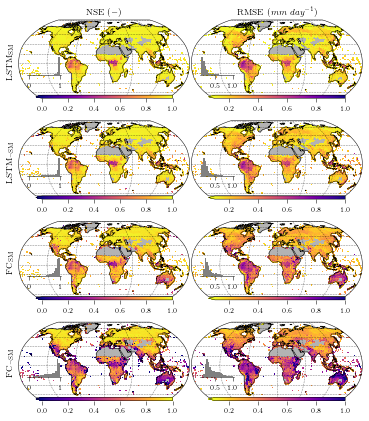

In [67]:
fig, axes = subplots_robinson(4, 2, figsize=(fig_size[0], fig_size[0]*1.2), gridspec_kw={'wspace': 0.01, 'hspace': 0.01})

for i, met in enumerate(['mef', 'rmse']):
    
    for j, (mod, mod_name) in enumerate(zip(['wn', 'nn', 'ww', 'nw'], [r'$\mathrm{LSTM_{SM}}$', r'$\mathrm{LSTM_{\neg SM}}$', r'$\mathrm{FC_{SM}}$', r'$\mathrm{FC_{\neg SM}}$'])):

        ax = axes[j, i]
        dt = metrics[met].sel(model=mod, timeres='daily', set='raw', cvset='eval')
        label = 'NSE ($-$)' if met=='mef' else 'RMSE ($mm \ day^{-1}$)'
        plot_map(
            dt, label=' ', rasterized=True, vmin=0 if met=='mef' else 0.1, vmax=1 if met=='mef' else 1, cmap='plasma' if met=='mef' else 'plasma_r', ax=ax,
            histogram_placement=[0.05, 0.27, 0.2, 0.25], hist_kw={'bins': 20, 'edgecolor': 'none'}, cbar_kwargs={'extend': 'min'})
        ax.set_title('')
        if i == 0:
            ax.text(-0.02, 0.45, mod_name, horizontalalignment='right', verticalalignment='center', transform=ax.transAxes, rotation=90, size=9)
        if j == 0:
            ax.set_title(label, size=9)
        ax.outline_patch.set_linewidth(0.5)

savefig('/workspace/bkraft/dl_chapter14/src/notebooks/exp1_figures/Fig2', dpi=300)

In [ ]:
plt.pcolormesh()

In [31]:
!cat '/scratch/dl_chapter14/experiments/et/w_sm.w_perm/hptune/summary/best_params.json'

{
  "dense_activation": "relu",
  "dense_hidden_size": 200,
  "dense_num_layers": 6,
  "dropout_in": 0.0,
  "dropout_linear": 0.0,
  "hc_config": {
    "batch_size": 64,
    "data_path": "/scratch/dl_chapter14/data/data.zarr/",
    "experiment_name": "w_sm.w_perm",
    "grace_period": 50,
    "halving_factor": 3,
    "input_vars": [
      "ccover",
      "lai",
      "lwdown",
      "swdown",
      "psurf",
      "qair",
      "tair",
      "wind",
      "rainf",
      "snowf",
      "mrlsl_shal",
      "mrlsl_deep"
    ],
    "input_vars_static": [
      "soil_properties",
      "pft"
    ],
    "is_temporal": false,
    "is_tune": true,
    "loss_fn": "MSE",
    "max_t": 120,
    "metric": "loss_eval",
    "ncpu_per_run": 10,
    "ngpu_per_run": 1.0,
    "num_samples": 134,
    "num_workers": 8,
    "optimizer": "Adam",
    "patience": 30,
    "pin_memory": false,
    "small_aoi": false,
    "store": "/scratch/dl_chapter14/experiments",
    "target_var": "et",
    "time": {
      "ev

In [119]:
for m in ('wn', 'nn', 'ww', 'nw'):
    print('model: ', m)
    pd_pft = df.loc[(df['timeres']=='daily') & (df['cvset']=='eval') & (df['model']==m), :].groupby(('pft', 'set'))
    pd_pft = pd.concat((pd_pft.mean(), pd_pft.count()['model']), axis=1).reset_index(level=['pft','set'])
    met = pd_pft.loc[(pd_pft['pft']==2) & (pd_pft['set']=='raw'),:].mean()
    print(f'NSE: {met["mef"]:0.2f}, {met["rmse"]:0.2f}')

model:  wn
NSE: 0.71, 0.48
model:  nn


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  This is separate from the ipykernel package so we can avoid doing imports until


NSE: 0.70, 0.48
model:  ww
NSE: 0.64, 0.55
model:  nw
NSE: 0.60, 0.57


In [126]:
met['rmse'].values

array([0.21018645])

In [128]:
for m in ('wn', 'nn', 'ww', 'nw'):
    print('model: ', m)
    pd_pft = df.loc[(df['timeres']=='daily') & (df['cvset']=='eval') & (df['model']==m), :].groupby(('pft', 'set'))
    pd_pft = pd.concat((pd_pft.mean(), pd_pft.count()['model']), axis=1).reset_index(level=['pft','set'])
    met = pd_pft.loc[(pd_pft['pft']!=2) & (pd_pft['set']=='raw'),:].groupby(('set')).mean()
    print(f'NSE: {met["mef"].values[0]:0.2f}, {met["rmse"].values[0]:0.2f}')

model:  wn
NSE: 0.95, 0.21
model:  nn


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  This is separate from the ipykernel package so we can avoid doing imports until


NSE: 0.94, 0.21
model:  ww
NSE: 0.87, 0.31
model:  nw
NSE: 0.81, 0.36


In [94]:
pd_pft = df.loc[(df['timeres']=='daily') & (df['cvset']=='eval') & (df['model']=='nn'), :].groupby(('pft', 'set'))
pd_pft = pd.concat((pd_pft.mean(), pd_pft.count()['model']), axis=1).reset_index(level=['pft','set'])
pd_pft

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


,pft,set,mef,rmse,model
0,2,ano,0.678900,0.461140,5112
1,2,iav,0.794918,0.043168,5112
2,2,msc,0.579744,0.111722,5112
3,2,raw,0.699384,0.482448,5112
4,3,ano,0.840044,0.231431,1693
5,3,iav,0.827647,0.021844,1693
6,3,msc,0.980368,0.048368,1693
7,3,raw,0.960902,0.238665,1693
8,4,ano,0.803231,0.258093,2251
9,4,iav,0.780242,0.024074,2251


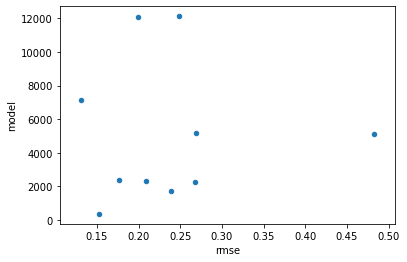

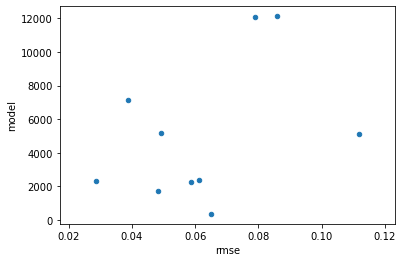

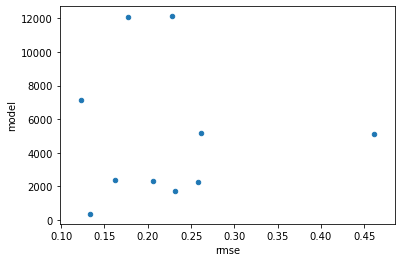

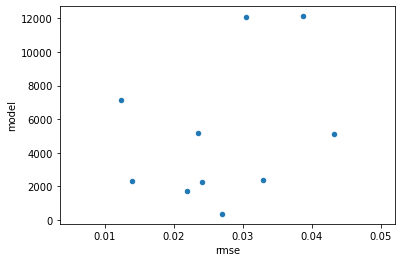

In [75]:
for s in ['raw', 'msc', 'ano', 'iav']:
    pd_pft.loc[pd_pft['set']==s, :].plot.scatter(x='rmse', y='model')

KeyError: 'eval'

In [ ]:
fig, axes = subplots_robinson(4, 4, figsize=(26, 16), gridspec_kw={'hspace': 0.0, 'wspace': 0.0})

# use mef, bias, metrics in columns

for i, (ds, title) in enumerate(zip([met_wn, met_nn, met_ww , met_nw], ['with SM\nno perm', 'no SM\nno perm', 'with SM\nwith perm', 'no SM\nwith perm'])):
    ax = axes[:, i]
    plot_map(ds.corr, vmin=0.5, vmax=1, ax=ax[0])
    plot_map(ds.rmse, vmin=0, vmax=0.00001, ax=ax[1])
    plot_map(ds.mef, vmin=0, vmax=1, ax=ax[2])
    plot_map(ds.bias, vmin=-0.000003, vmax=0.000003, ax=ax[3])
    ax[0].set_title(title)

In [ ]:
plot_map(metrics.isel(set=1, timeres=1, model=2).mef, robust=True)

In [ ]:
fig, axes = subplots_robinson(4, 4, figsize=(26, 16), gridspec_kw={'hspace': 0.0, 'wspace': 0.0})

# use mef, bias, metrics in columns

for i, (ds, title) in enumerate(zip([met_wn, met_nn, met_ww , met_nw], ['with SM\nno perm', 'no SM\nno perm', 'with SM\nwith perm', 'no SM\nwith perm'])):
    ax = axes[:, i]
    plot_map(ds.corr, vmin=0.5, vmax=1, ax=ax[0])
    plot_map(ds.rmse, vmin=0, vmax=0.00001, ax=ax[1])
    plot_map(ds.mef, vmin=0, vmax=1, ax=ax[2])
    plot_map(ds.bias, vmin=-0.000003, vmax=0.000003, ax=ax[3])
    ax[0].set_title(title)

In [ ]:
fig, axes = subplots_robinson(4, 4, figsize=(26, 16), gridspec_kw={'hspace': 0.0, 'wspace': 0.0})

for i, (ds, title) in enumerate(zip([met_wn, met_nn, met_ww , met_nw], ['with SM\nno perm', 'no SM\nno perm', 'with SM\nwith perm', 'no SM\nwith perm'])):
    ax = axes[:, i]
    plot_map(ds.corr, vmin=0.5, vmax=1, ax=ax[0])
    plot_map(ds.rmse, vmin=0, vmax=0.00001, ax=ax[1])
    plot_map(ds.mef, vmin=0, vmax=1, ax=ax[2])
    plot_map(ds.bias, vmin=-0.000003, vmax=0.000003, ax=ax[3])
    ax[0].set_title(title)

In [ ]:
fig, axes = subplots_robinson(figsize=(26, 16), gridspec_kw={'hspace': 0.0, 'wspace': 0.0})
plot_map((met_nn.corr-met_nw.corr)-(met_ww.corr-met_nw.corr), ax=axes, vmin=0, robust=True)

In [ ]:
fig, axes = subplots_robinson(figsize=(26, 16), gridspec_kw={'hspace': 0.0, 'wspace': 0.0})
plot_map((met_nn.corr-met_nw.corr)-(met_ww.corr-met_nw.corr), ax=axes, vmin=0, robust=True)

In [ ]:
dst_nn_msc = dst_nn.groupby('time.dayofyear').mean('time')

In [ ]:
dst_nn

In [ ]:
with ProgressBar():
    msc = dst_nn.groupby('time.dayofyear').mean('time')
    msc.to_zarr('/scratch/dl_chapter14/experiments/et/n_sm.n_perm/inference/pred_to_msc.zarr/')

In [ ]:
with ProgressBar():
    msc = dst_ww.groupby('time.dayofyear').mean('time')
    msc.to_zarr('/scratch/dl_chapter14/experiments/et/w_sm.w_perm/inference/pred_to_msc.zarr/')

In [ ]:
with ProgressBar():
    msc = dst_nw.groupby('time.dayofyear').mean('time')
    msc.to_zarr('/scratch/dl_chapter14/experiments/et/n_sm.w_perm/inference/pred_to_msc.zarr/')

In [ ]:
with ProgressBar():
    msc = dst_wn.groupby('time.dayofyear').mean('time')
    msc.to_zarr('/scratch/dl_chapter14/experiments/et/w_sm.n_perm/inference/pred_to_msc.zarr/')

In [ ]:
with ProgressBar():
    msc = xr.open_zarr('/scratch/dl_chapter14/experiments/et/n_sm.n_perm/inference/pred_to_msc.zarr/')
    (dst_nn - msc).to_zarr('/scratch/dl_chapter14/experiments/et/n_sm.n_perm/inference/pred_to_ano.zarr/')

In [ ]:
with ProgressBar():
    msc = xr.open_zarr('/scratch/dl_chapter14/experiments/et/w_sm.w_perm/inference/pred_to_msc.zarr/')
    (dst_ww - msc).to_zarr('/scratch/dl_chapter14/experiments/et/w_sm.w_perm/inference/pred_to_ano.zarr/')

In [ ]:
with ProgressBar():
    msc = xr.open_zarr('/scratch/dl_chapter14/experiments/et/n_sm.w_perm/inference/pred_to_msc.zarr/')
    (dst_nw - msc).to_zarr('/scratch/dl_chapter14/experiments/et/n_sm.w_perm/inference/pred_to_ano.zarr/')

In [ ]:
with ProgressBar():
    msc = xr.open_zarr('/scratch/dl_chapter14/experiments/et/w_sm.n_perm/inference/pred_to_msc.zarr/')
    (dst_wn - msc).to_zarr('/scratch/dl_chapter14/experiments/et/w_sm.n_perm/inference/pred_to_ano.zarr/')

In [ ]:
(dst_nn - msc)

In [ ]:
msc

In [ ]:
msc = xr.open_zarr('/scratch/dl_chapter14/experiments/et/n_sm.n_perm/inference/pred_to_msc.zarr/')

In [ ]:
msc.sel(lat=45, lon=8, method='nearest').mod.plot()
msc.sel(lat=45, lon=8, method='nearest').obs.plot()

In [ ]:
xr.apply_ufunc(
    calc_msc_ano, dst_nn,
    dask='parallelized',
    output_dtypes=[float]
).compute()

In [ ]:
with ProgressBar():
    dst_nn_msc = dst_nn.groupby('time.dayofyear').mean('time').compute()

In [ ]:
def plot_time_series(
        x, y,
        xlabel='mod', ylabel='obs',
        timeagg=None,
        title='',
        ax=None,
        figsize=(15, 5),
        subplot_kw={},
        **kwargs):

    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.subplot(**subplot_kw)

    if timeagg is not None:
        x = x.resample(time=timeagg).mean()
        y = y.resample(time=timeagg).mean()

    time = x.time.values

    x_m = x.mean(dim=['lat', 'lon'])
    y_m = y.mean(dim=['lat', 'lon'])

    x_qs = xr_quantile(x, [0.25, 0.75], dim=['lat', 'lon'])
    y_qs = xr_quantile(y, [0.25, 0.75], dim=['lat', 'lon'])

    ax.fill_between(time, x_qs.isel(quantile=0), x_qs.isel(quantile=1), alpha=0.2, facecolor='tab:blue', label=r'$modeled_{q0.2-0.8}$')
    ax.fill_between(time, y_qs.isel(quantile=0), y_qs.isel(quantile=1), alpha=0.2, facecolor='k', label=r'$observed_{q0.2-0.8}$')
    ax.plot(time, x_m, alpha=1.0, color='tab:blue', linewidth=2., label=r'$modeled_{median}$')
    ax.plot(time, y_m, color='k', linewidth=1.2, linestyle='--', label=r'$observed_{median}$')

    # ax.text(0.05, 0.95, f'r={r:.3f}', horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)
    
    # ax.set_ylabel(var)
    
    ax.legend()

    ax.patch.set_facecolor('white')

In [ ]:
plot_time_series(dss.mod, dss.obs)

In [ ]:
plot_time_series(dss.mod, dss.obs)

In [ ]:
ts = dst_nw.sel(lat=46, lon=8, method='nearest')

In [ ]:
ts

In [ ]:
plt.figure(figsize=(35, 7))
ts.obs.isel(time=slice(0, 1000)).plot(alpha=0.5, color='k')
ts.mod.isel(time=slice(0, 1000)).plot(color='orangered', alpha=0.5)

In [ ]:
%time dst_nn_msc = dst_nn.groupby('time.dayofyear').mean().compute()

In [ ]:
ts_msc.mod.plot()

In [ ]:
dst_nn_msc

In [ ]:
dst_nn_msc.mod.values[1, 1, 1]

In [ ]:
plot_map(dst_nn_msc.mod.isel(dayofyear=0))

In [ ]:
plot_map(dst_nn_msc.obs.isel(dayofyear=0))

In [ ]:
def _single_xr_quantile(x, q, dim):
    if isinstance(dim, str):
        dim = [dim]
    ndims = len(dim)
    axes = tuple(np.arange(ndims)-ndims)
    m = xr.apply_ufunc(
        np.nanquantile, x,
        input_core_dims=[dim],
        dask='parallelized',
        output_dtypes=[float],
        keep_attrs=True,
        kwargs={'q': q, 'axis': axes})
    m.name = 'quantile'
    return m

def xr_quantile(x, q, dim):
    if not hasattr([1, 2], '__iter__'):
        q = [q]
    quantiles = []
    for i, q_ in enumerate(q):
        r = _single_xr_quantile(x, q_, dim).compute()
        quantiles.append(r)
    quantiles = xr.concat(quantiles, 'quantile')
    quantiles['quantile'] = q
    quantiles.attrs.update({**x.attrs})


    return quantiles

In [ ]:
qs = xr_quantile(dss.obs, [0.25, 0.5, 0.75], dim=['lat', 'lon'])

In [ ]:
qs

In [ ]:
qs.isel(quantile=0).plot()
qs.isel(quantile=1).plot()
qs.isel(quantile=2).plot()

In [ ]:
med.

In [ ]:
xr.merge(qs)

In [ ]:
med = xr_quantile(dss.obs, [0.25, 0.75], dim=['lat', 'lon']).compute()

In [ ]:
plt.plot(med)

In [ ]:
med = xr_median(dst.obs, dim=['time']).compute()

In [ ]:
plot_map(med)

In [ ]:
plt.figure(figsize=(30, 7))

plt.plot(dss.obs.mean(('lat', 'lon')), 'k--', label='obs global mean')
plt.plot(dss.mod.mean(('lat', 'lon')), alpha=0.5, label='mod global mean')
plt.legend()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def f0(x):
    return x**(-0.5)
def f1(x):
    return x**(-0.2) + 0.01 * x
def f_gl(x):
    gl = np.zeros_like(x)
    for t, v in enumerate(x):
        gl[t] = 100 * (v / np.min(x[:t+1]) - 1)
    return gl
def f_min(x):
    m = np.zeros_like(x)
    for t, v in enumerate(x):
        m[t] = np.min(x[:t+1])
    return m

In [ ]:
t = np.linspace(0, 60, 400)
e_tr = f0(t)
e_va = f1(t)
gl = f_gl(e_va)
gl_tr = f_gl(e_tr)
plt.plot(e_va)
plt.plot(e_tr)
plt.plot(gl)
# plt.plot(gl_tr)

In [ ]:
def f_gl(x):
    per_impr = np.zeros_like(x)
    for t in range(1, len(x)):
        per_impr[t] = 100 * (1 - x[t] / x[t-1])
    return per_impr

In [ ]:
gl = f_gl(e_va)

In [ ]:
plt.plot(e_va[1:])
plt.plot(gl[1:])

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/scratch/dl_chapter14/experiments/hydro/default/tune/hydro/Emulator_117_dropout_in=0.6,dropout_linear=0.1,dropout_lstm=0.6,batch_size=32,dynamic_path=_scratch_dl_chapter14_input_dynamic_gsw_2019-11-14_08-49-30_h07l5k6/progress.csv')
df.keys()

In [ ]:
df

In [ ]:
plt.plot(df['wloss_eval'])

In [ ]:
plt.plot(df['loss_eval'])

In [ ]:
plt.plot(df['perc_improved'])

In [ ]:
plt.plot(df['patience_counter'])

In [ ]:
l = {'a': 1, 'b': 2}
options_str = ", ".join(l.keys())
print(f'[{options_str}]')

In [ ]:
print(f'{getattr.__name__}')

In [ ]:
from datetime import datetime

In [ ]:
tic = datetime.now()

In [ ]:
tic.strftime("%m/%d/%Y, %H:%M:%S")

In [ ]:
toc = datetime.now()

In [ ]:
elapsed = toc- tic

In [ ]:
elapsed.seconds

In [ ]:
mins = int(elapsed.seconds/60)
mins

In [ ]:
secs = int(elapsed.seconds - 60 * mins)
secs

In [ ]:
import xarray as xr
import numpy as np
import zarr

In [ ]:
ds_ssd = zarr.open_group('/scratch/dl_chapter14/experiments/hydro/default/pred/predictions.zarr/')
ds_ram = zarr.open_group('/run/user/196')
ds_ram.tree()

In [ ]:
def read_zarr(ds, n):
    for i in range(n):
        lat = np.random.choice(360)
        lon = np.random.choice(720)
        s = ds['mrro'][:, lat, lon] + 1

In [ ]:
%time read_zarr(ds_ssd, 1000)

In [ ]:
%time read_zarr(ds_ssd, 1000)

In [ ]:
ls -l /run/user/1968

In [ ]:
/scratch/

In [ ]:
import torch
import numpy as np

In [ ]:
class RNN(torch.nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = torch.nn.RNN(1, 5)
    def forward(self, x):
        out = self.rnn(x)
        return out


In [ ]:
import xarray as xr

In [ ]:
ds = xr.open_zarr('/scratch/dl_chapter14/experiments/hydro/default/pred/predictions.zarr/')

In [ ]:
ds

In [ ]:
pred = xr.Dataset({
    'obs': xr.DataArray(ds.values, coords=[ds.lat, ds.lon, ds.time]),
    'mod': xr.DataArray(ds.values, coords=[ds.lat, ds.lon, ds.time])
})
pred.attrs = ds.attrs

In [ ]:
xr.Dataset({
    'mod': xr.DataArray(ds.mrro.values, coords=[dslat, ds.lon, ds.time),
    'obs': xr.ones_like(ds.coords) * ds.mrro.values
})

In [ ]:
ds

In [ ]:
ds = xr.open_zarr('/scratch/dl_chapter14/target/dynamic/koirala2017.zarr/')
ds

In [ ]:
plot_map(ds.wtd.isel(time=0), robust=True)

In [ ]:
p = xr.open_zarr('/scratch/hydrodl/data/bucket.zarr/prec/')

In [ ]:
p_missing = p.data.isnull().sum('time').compute()

In [ ]:
plot_map(p_missing)

In [ ]:
xr.open_zarr('/scratch/dl_chapter14/target/dynamic/koirala2017.zarr/')

In [ ]:
xr.open_dataset('/workspace/BGI/people/skoirala/spmip/matsiro-gw.run1_20180805/matsiro-gw_experiment_1_1982.nc')

In [ ]:
ds_frac = xr.open_dataset('/workspace/BGI/people/skoirala/spmip/matsiro-gw.run1_20180805/matsiro-gw_experiment_1_1982.nc')['mrlslfrac']
ds = xr.open_dataset('/workspace/BGI/people/skoirala/spmip/matsiro-gw.run1_20180805/matsiro-gw_experiment_1_1982.nc')['rzwc']

In [ ]:
ds

In [ ]:
ds_frac_mean = ds_frac.mean(('time', 'level'))
ds_mean = ds.mean(('time', 'level'))

In [ ]:
plt.figure(figsize=(17, 12))
plt.imshow(ds_frac_mean.values, vmin=0.2, vmax=0.6)

In [ ]:
plt.figure(figsize=(17, 12))
plt.imshow(ds_mean.values)

In [ ]:
plot_map(ds_mean)

In [ ]:
"et", "tws", "mrro", "wtd", "mrlslfrac"

In [ ]:
t = xr.open_dataset('/workspace/BGI/people/skoirala/spmip/full_matsiro-gw_exp3.run1_20180805_latlonReverse/full_matsiro-gw_exp3_experiment_3_1950.nc')

In [ ]:
t

In [ ]:
plot_map(t.mrlslfrac.isel(levelc=1, time=0), robust=True)

In [ ]:
ls -l /workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/

In [ ]:
e


#### input vars

| var  | dims | path |
| ---  | ---  | ---  |
| Rainf  | lat, lon, time | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/Rainf/' |
| Snowf  | lat, lon, time | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/Snowf/' |
| SWdown  | lat, lon, time | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/SWdown/' |
| LWdown  | lat, lon, time | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/LWdown/' |
| Tair  | lat, lon, time | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/Tair/' |
| Wind  | lat, lon, time | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/Wind/' |
| Qair  | lat, lon, time | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/Qair/' |
| PSurf  | lat, lon, time | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/PSurf/' |
| lai | lat, lon, time | '/workspace/BGI/work_3/dl_chapter14/input_data/org_data/matsiro-gw_lai.nc' |
| ccover | lat, lon, time | '/workspace/BGI/work_3/dl_chapter14/input_data/org_data/matsiro-gw_lai.nc' |
| PFT | lat, lon | '/workspace/BGI/work_3/dl_chapter14/input_data/org_data/matsiro-gw_PFT.nc' |
| soil_properties | lat, lon | '/workspace/BGI/work_3/dl_chapter14/input_data/org_data/matsiro-gw_soil_propreties.nc' |

#### Target vars

| var  | dims | path |
| ---  | ---  | ---  |
| et (also input) | lat, lon, time | '/workspace/BGI/people/skoirala/spmip/full_matsiro-gw_exp3.run1_20180805_latlonReverse/full_matsiro-gw_exp3_experiment_3_YYYY.nc' |
| mrlslfrac (mean of first 4 levels)  | lat, lon, time | '/workspace/BGI/people/skoirala/spmip/full_matsiro-gw_exp3.run1_20180805_latlonReverse/full_matsiro-gw_exp3_experiment_3_YYYY.nc' |
| tws  | lat, lon, time | '/workspace/BGI/people/skoirala/spmip/full_matsiro-gw_exp3.run1_20180805_latlonReverse/full_matsiro-gw_exp3_experiment_3_YYYY.nc' |
| mrro  | lat, lon, time | '/workspace/BGI/people/skoirala/spmip/full_matsiro-gw_exp3.run1_20180805_latlonReverse/full_matsiro-gw_exp3_experiment_3_YYYY.nc' |


In [ ]:
import xarray as xr

In [ ]:
d = xr.open_dataset('/workspace/BGI/work_3/dl_chapter14/input_data/org_data/matsiro-gw_soil_propreties.nc')
d

In [ ]:
plot_map(d.PFT)

In [ ]:
from matplotlib import animation
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import LogNorm
from matplotlib import animation, rc
from IPython.display import HTML, Image
rc('animation', html='html5')
%matplotlib inline

In [ ]:
ds = xr.open_zarr('/scratch/hydrodl/data/bucket.zarr/et/').data

In [ ]:
ds.isel(time=[0, 4, 8]).values.shape

In [ ]:
ax = plt.subplot(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines(color='white')
ax.gridlines()
ax.imshow(ds.isel(time=[0, 4, 8]).values.transpose(1, 2, 0)[-1::-1,:,:], transform=ccrs.PlateCarree())
# (ds.isel(time=[0, 4, 8])).plot.imshow(robust=True, ax=ax, transform=ccrs.PlateCarree())

In [ ]:
import cartopy.crs as ccrs
import xarray
import matplotlib.pyplot as plt

#ds = xr.load_dataset(...)

ax = plt.subplot(projection=ccrs.Robinson())
(ds.isel(time=[0, 4, 8])).plot.imshow(ax=ax, transform=ccrs.PlateCarree())

In [ ]:
ax = plt.subplot(projection=ccrs.Robinson())
ax.imshow(ds.isel(time=[0, 4, 8]).transpose('lat', 'lon', 'time').values[-1::-1, :, :], transform=ccrs.PlateCarree())

In [ ]:
ax = plt.subplot(projection=ccrs.Robinson())
plt.plot(ds.isel(time=[0, 4, 8]).transpose('lat', 'lon', 'time').values[-1::-1, :, :], transform=ccrs.PlateCarree(), ax=ax)

In [ ]:
import cartopy.crs as ccrs
import xarray
import matplotlib.pyplot as plt

#ds = xr.load_dataset(...)

ax = plt.subplot(projection=ccrs.Robinson())
(ds.isel(time=0)).plot.imshow(robust=True, ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False)

In [ ]:
xr.__version__

In [ ]:
mpl.__version__

In [13]:
ds

,Array,Chunk
Bytes,10.60 GB,9.21 MB
Shape,"(5114, 360, 720)","(5114, 15, 15)"
Count,2305 Tasks,1152 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,10.60 GB,9.21 MB
Shape,"(5114, 360, 720)","(5114, 15, 15)"
Count,2305 Tasks,1152 Chunks
Type,float64,numpy.ndarray


In [ ]:
et

In [7]:
fig_width_pt = 443.57848                # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.                # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "xelatex",         # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],  # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 9,                # LaTeX default is 10pt font.
    "font.size": 7,
    "legend.fontsize": 9,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "figure.figsize": fig_size,        # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
mpl.rcParams.update(pgf_with_latex)

In [8]:
pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "xelatex",         # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],  # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 9,                # LaTeX default is 10pt font.
    "font.size": 7,
    "legend.fontsize": 9,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "figure.figsize": fig_size,        # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
mpl.rcParams.update(pgf_with_latex)

In [23]:
def savefig(filename, **kwargs):
    #plt.savefig('{}.pgf'.format(filename), pad_inches = 0, bbox_inches='tight')
    plt.savefig('{}.pdf'.format(filename), pad_inches = 0, bbox_inches='tight', **kwargs)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['monospace'] not found. Falling back to DejaVu Sans.


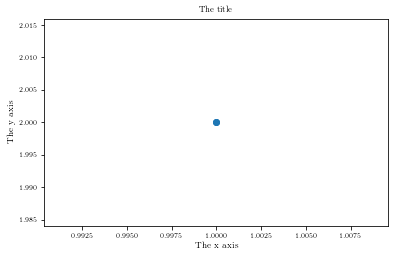

In [10]:
fig, ax = plt.subplots()
ax.scatter([1, 1], [2, 2])
ax.set_title('The title')
ax.set_xlabel('The x axis')
ax.set_ylabel('The y axis')
savefig('/workspace/bkraft/dl_chapter14/src/notebooks/test')

In [14]:
fig_size

[6.160812222222222, 3.8075913516391036]

AttributeError: 'QuadMesh' object has no property 'rasterize'

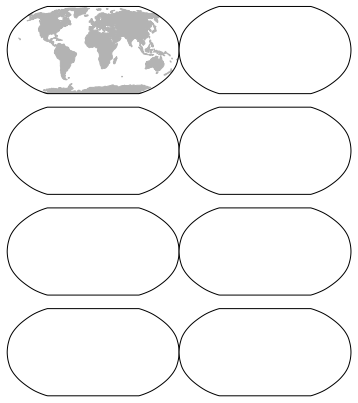

In [24]:
fig, axes = subplots_robinson(4, 2, figsize=(6.160812222222222, 6.160812222222222*1.2), gridspec_kw={'wspace': 0, 'hspace': 0.01})

for i, met in enumerate(['mef', 'rmse']):
    
    for j, (mod, mod_name) in enumerate(zip(['wn', 'nn', 'ww', 'nw'], [r'$\mathrm{LSTM_{SM}}$', r'$\mathrm{LSTM_{\neg SM}}$', r'$\mathrm{FC_{SM}}$', r'$\mathrm{FC_{\neg SM}}$'])):

        ax = axes[j, i]
        dt = metrics[met].sel(model=mod, timeres='daily', set='raw', cvset='eval')
        label = f"{'NSE' if met=='mef' else 'RMSE'} ({'-' if met=='mef' else r'mm d-1'})"
        plot_map(
            dt, label=' ', vmin=0 if met=='mef' else 0.1, vmax=1 if met=='mef' else 1, cmap='plasma' if met=='mef' else 'plasma_r', ax=ax,
            histogram_placement=[0.05, 0.27, 0.2, 0.25], hist_kw={'bins': 20, 'edgecolor': 'none'}, cbar_kwargs={'extend': 'min'}, rasterize=True)
        ax.set_title('')
        if i == 0:
            ax.text(-0.02, 0.45, mod_name, horizontalalignment='right', verticalalignment='center', transform=ax.transAxes, rotation=90, size=9)
        if j == 0:
            ax.set_title(label, size=9)

savefig('/workspace/bkraft/dl_chapter14/src/notebooks/test')

#fig.savefig('/workspace/bkraft/dl_chapter14/src/notebooks/exp1_figures/map_mef_bias_raw_daily.png', dpi=300, bbox_inches='tight')

In [25]:
from inspect import getmembers, isclass
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def rasterize_and_save(fname, rasterize_list=None, fig=None, dpi=None,
                       savefig_kw={}):
    """Save a figure with raster and vector components
    This function lets you specify which objects to rasterize at the export
    stage, rather than within each plotting call. Rasterizing certain
    components of a complex figure can significantly reduce file size.
    Inputs
    ------
    fname : str
        Output filename with extension
    rasterize_list : list (or object)
        List of objects to rasterize (or a single object to rasterize)
    fig : matplotlib figure object
        Defaults to current figure
    dpi : int
        Resolution (dots per inch) for rasterizing
    savefig_kw : dict
        Extra keywords to pass to matplotlib.pyplot.savefig
    If rasterize_list is not specified, then all contour, pcolor, and
    collects objects (e.g., ``scatter, fill_between`` etc) will be
    rasterized
    Note: does not work correctly with round=True in Basemap
    Example
    -------
    Rasterize the contour, pcolor, and scatter plots, but not the line
    >>> import matplotlib.pyplot as plt
    >>> from numpy.random import random
    >>> X, Y, Z = random((9, 9)), random((9, 9)), random((9, 9))
    >>> fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2)
    >>> cax1 = ax1.contourf(Z)
    >>> cax2 = ax2.scatter(X, Y, s=Z)
    >>> cax3 = ax3.pcolormesh(Z)
    >>> cax4 = ax4.plot(Z[:, 0])
    >>> rasterize_list = [cax1, cax2, cax3]
    >>> rasterize_and_save('out.svg', rasterize_list, fig=fig, dpi=300)
    """

    # Behave like pyplot and act on current figure if no figure is specified
    fig = plt.gcf() if fig is None else fig

    # Need to set_rasterization_zorder in order for rasterizing to work
    zorder = -5  # Somewhat arbitrary, just ensuring less than 0

    if rasterize_list is None:
        # Have a guess at stuff that should be rasterised
        types_to_raster = ['QuadMesh', 'Contour', 'collections']
        rasterize_list = []

        print("""
        No rasterize_list specified, so the following objects will
        be rasterized: """)
        # Get all axes, and then get objects within axes
        for ax in fig.get_axes():
            for item in ax.get_children():
                if any(x in str(item) for x in types_to_raster):
                    rasterize_list.append(item)
        print('\n'.join([str(x) for x in rasterize_list]))
    else:
        # Allow rasterize_list to be input as an object to rasterize
        if type(rasterize_list) != list:
            rasterize_list = [rasterize_list]

    for item in rasterize_list:

        # Whether or not plot is a contour plot is important
        is_contour = (isinstance(item, matplotlib.contour.QuadContourSet) or
                      isinstance(item, matplotlib.tri.TriContourSet))

        # Whether or not collection of lines
        # This is commented as we seldom want to rasterize lines
        # is_lines = isinstance(item, matplotlib.collections.LineCollection)

        # Whether or not current item is list of patches
        all_patch_types = tuple(
            x[1] for x in getmembers(matplotlib.patches, isclass))
        try:
            is_patch_list = isinstance(item[0], all_patch_types)
        except TypeError:
            is_patch_list = False

        # Convert to rasterized mode and then change zorder properties
        if is_contour:
            curr_ax = item.ax.axes
            curr_ax.set_rasterization_zorder(zorder)
            # For contour plots, need to set each part of the contour
            # collection individually
            for contour_level in item.collections:
                contour_level.set_zorder(zorder - 1)
                contour_level.set_rasterized(True)
        elif is_patch_list:
            # For list of patches, need to set zorder for each patch
            for patch in item:
                curr_ax = patch.axes
                curr_ax.set_rasterization_zorder(zorder)
                patch.set_zorder(zorder - 1)
                patch.set_rasterized(True)
        else:
            # For all other objects, we can just do it all at once
            curr_ax = item.axes
            curr_ax.set_rasterization_zorder(zorder)
            item.set_rasterized(True)
            item.set_zorder(zorder - 1)

    # dpi is a savefig keyword argument, but treat it as special since it is
    # important to this function
    if dpi is not None:
        savefig_kw['dpi'] = dpi

    # Save resulting figure
    fig.savefig(fname, **savefig_kw)

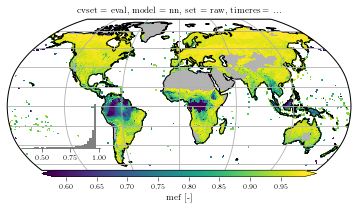

In [22]:
fig, ax = subplots_robinson()
plot_map(metrics['mef'].sel(model='nn', timeres='daily', set='raw', cvset='eval'), robust=True, rasterized=True, ax=ax)
fig.savefig('/workspace/bkraft/plots/test.pdf')

In [18]:
img.axes.artists[0]

In [10]:
fig, ax = new_subplots(2, 2, 0.7, sharey='row', sharex=True, gridspec_kw={'wspace': 0.01, 'hspace': 0.1})

sb.set_style("whitegrid")
sb.boxplot(x="set", y="mef", hue="model", linewidth=0.5, data=df.loc[(df['timeres']=='daily') & (df['cvset']=='train'), :], showfliers=False, ax=ax[0, 0], order=order, hue_order=hue_order, palette='Paired')
sb.boxplot(x="set", y="mef", hue="model", linewidth=0.5, data=df.loc[(df['timeres']=='daily') & (df['cvset']=='eval'), :], showfliers=False, ax=ax[0, 1], order=order, hue_order=hue_order, palette='Paired')
sb.boxplot(x="set", y="rmse", hue="model", linewidth=0.5, data=df.loc[(df['timeres']=='daily') & (df['cvset']=='train'), :], showfliers=False, ax=ax[1, 0], order=order, hue_order=hue_order, palette='Paired')
sb.boxplot(x="set", y="rmse", hue="model", linewidth=0.5, data=df.loc[(df['timeres']=='daily') & (df['cvset']=='eval'), :], showfliers=False, ax=ax[1, 1], order=order, hue_order=hue_order, palette='Paired')

ax[0, 0].legend().set_visible(False)
ax[0, 1].legend().set_visible(False)
ax[1, 0].legend().set_visible(False)
ax[1, 1].legend().set_visible(False)

legend = ax[1, 0].legend(loc='upper center', bbox_to_anchor=(1.0, -0.15), ncol=4, title='', frameon=False)
for t, l in zip(legend.texts, [r'$\mathrm{LSTM_{SM}}$', r'$\mathrm{LSTM_{\neg SM}}$', r'$\mathrm{FC_{SM}}$', r'$\mathrm{FC_{\neg SM}}$']):
    t.set_text(l)
    
ax[1, 0].set_xticklabels(['daily', 'daily\nseas. cycle', 'daily\nanomalies', 'interannual\nanomalies']);
ax[1, 1].set_xticklabels(['daily', 'daily\nseas. cycle', 'daily\nanomalies', 'interannual\nanomalies']);
ax[1, 0].set_xlabel('', fontsize=12)
ax[1, 1].set_xlabel('', fontsize=12)
ax[0, 0].set_ylabel('NSE (-)')
ax[1, 0].set_ylabel('RMSE (mm d-1)')
ax[0, 1].set_ylim(-0.6, 1.001);
ax[1, 1].set_ylim(0, 1.0);

for ax_ in ax.flat:
    ax_.label_outer()
    # ax_.grid(axis='y', linestyle='--', color='0.2')

ax[0, 0].set_title('training', size=9)
ax[0, 1].set_title('test', size=9)

fig.align_ylabels(ax[:, 0])


# fig.savefig('/workspace/bkraft/dl_chapter14/src/notebooks/exp1_figures/boxplot.pgf')
# savefig('/workspace/bkraft/dl_chapter14/src/notebooks/exp1_figures/boxplot')

NameError: name 'figsize' is not defined

<Figure size 432x288 with 0 Axes>